# Extracting meaningful relationships between commonly-traded commodities
## COMPSCI 760 PB3 Hybrid GAT&LSTM model

### Required Libaries

In [14]:
# General Libraries
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import timedelta, date
# Model Libraries
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
import torch_geometric.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

### Ignore Pandas Warning

In [15]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

### Alter those 5 parameters to see the effect on the model

In [2]:
#N: Using previous N weeks to predict the next week
N = 6
#F: Feature inputted into GAT
F = ["Close", "ROI"]
#O: Output feature size before the GAT’s last layer 
O = 8
# H: Attention mechanism number (heads)
H = 2
# L: Number of hidden feature size in LSTM
# L = [L for crypto, L for stock, L for the others]
L = [32, 16, 32]

TEST_PERCENT = 0.2
# Percentage of the last timestamps as test set

## Import Data

In [3]:
#Read in all Data
def read_data(file_paths):
    read_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
    data = pd.DataFrame()
    file_index = 0
    names, crypto, stock, others = [], [], [], []
    
    for files in file_paths:
        for f in files:
            if file_index == 0:
                csv = pd.read_csv(f, usecols = read_cols)
                name = str(f)[17:-4]
                for col in read_cols[1:]:
                    csv.rename(columns={col : col + " " + str(f)[17:-4]}, inplace=True)
                csv["Date"] = pd.to_datetime(csv["Date"])
                data = data.append(csv)
            else:
                csv = pd.read_csv(f, usecols = read_cols)
                if file_paths.index(files) == 2:
                    name = str(f)[22:-4]
                    for col in read_cols[1:]:
                        csv.rename(columns={col : col + " " + str(f)[22:-4]}, inplace=True)
                else:
                    name = str(f)[17:-4]
                    for col in read_cols[1:]:
                        csv.rename(columns={col : col +  " " + str(f)[17:-4]}, inplace=True)
                csv["Date"] = pd.to_datetime(csv["Date"])
                data = pd.merge(data, csv, on = "Date", how = "outer")
            names.append(name)
            if file_paths.index(files) == 0:
                crypto.append(name)
            elif file_paths.index(files) == 1:
                stock.append(name)
            elif file_paths.index(files) == 2:
                others.append(name)
            file_index += 1
    
    for c in data.columns[1:]: # Tidy data
        data[c] = data[c].astype(float)
    
    #data.fillna(method="pad", inplace=True) # Replace Missing Value with last day's value
    
    return data, names, crypto, stock, others

def clean_data(all_data):
    """
    Turn daily data into weekly and normalize the data
    """
    #drop_indices = [ind for ind in range(all_data.shape[0]) if (ind + 1) % 7 != 1]
    # "if (ind + 1) % 7 != 1" 1 here indicates select Monday and drop the others
    #all_data.drop(drop_indices, inplace=True)
    #all_data = all_data.reset_index(drop=True)
    
    data = pd.DataFrame(columns=all_data.columns)
    startDate = all_data.loc[0,"Date"]
    endDate = startDate.replace(startDate.year + 2)
    weekStart = startDate
    weekEnd = weekStart+timedelta(days = 7)
    while(weekEnd < endDate):
        mask = (all_data['Date'] >= weekStart) & (all_data['Date'] < weekEnd)
        weeklyData = all_data.loc[mask]
        newRow = {}
        for (columnName, columnData) in weeklyData.iteritems():
            if(columnName == "Date"):
                newRow["Date"]=weekStart
            else:
                newRow[columnName]=weeklyData[columnName].mean()
        data=data.append(newRow,ignore_index=True)
        weekStart = weekEnd
        weekEnd = weekEnd+timedelta(days = 7)
    
    #scaler = StandardScaler()
    #for col in data.columns[1:]:
        #data[col] = scaler.fit_transform(data[col].values.reshape(-1,1)).ravel()
    
    
    
    # Normalize the data
    #scaler = MinMaxScaler(feature_range = (-1, 1))
    #for col in all_data.columns[1:]:
        #all_data[col] = scaler.fit_transform(all_data[col].values.reshape(-1,1))
    #scaler = StandardScaler()
    #for col in all_data.columns[1:]:
        #all_data[col] = scaler.fit_transform(all_data[col].values.reshape(-1,1)).ravel()
 
    return data

def add_return_ratio(origin_data,normalize_data):
    read_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
    index=len(read_cols)
    for (columnName, columnData) in origin_data.iteritems():
        return_tratio = [];
        if("Close " in columnName):
            for i in range(len(columnData)):
                if i == 0:
                    return_tratio.append(0)
                else:
                    return_tratio.append((columnData[i]-columnData[i-1])/columnData[i-1])
            normalize_data.insert(index,columnName.replace("Close ","ROI "),return_tratio)
            index=index+len(read_cols)
    return normalize_data

def normalize_data(all_data):
    scaler = StandardScaler()
    for col in all_data.columns[1:]:
        all_data[col] = scaler.fit_transform(all_data[col].values.reshape(-1,1)).ravel()
    return all_data

def get_used_data(data, stock_names, used_features):
    used_data = pd.DataFrame()
    used_data["Date"] = data["Date"].copy()
    all_features_num = int((data.shape[1] - 1) // len(stock_names))
    for asset_id in range(len(stock_names)):
        for feature_id in range(all_features_num):
            col_name = data.columns[asset_id*all_features_num+feature_id+1]
            if col_name.split()[0] in used_features:
                used_data[col_name] = all_data[col_name].copy()
    return used_data

In [4]:
file_paths = [glob.glob("./Dataset/Crypto/*.csv"), glob.glob("./Dataset/Stocks/*.csv"), glob.glob("./Dataset/Commodities/*.csv")]
feature_num = len(F) - 1
all_data, names, crypto, stock, others= read_data(file_paths)

all_data = clean_data(all_data)
origin_data = all_data.copy()

normalise_data=normalize_data(all_data)
all_data = add_return_ratio(origin_data,normalise_data)
all_data.isnull().values.any() # Returns False if there is no Missing Value

used_data = get_used_data(all_data, names, F)
used_data = used_data.copy()
#all_data.head(all_data.shape[0])

### Train Test Split

In [5]:
def clean_train_test_data(train_data, test_data):
    #scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = StandardScaler()
    for col in train_data.columns[1:]:
        scaler.fit(train_data[col].values.reshape(-1,1))
        train_data[col] = scaler.transform(train_data[col].values.reshape(-1,1)).ravel()
        test_data[col] = scaler.transform(test_data[col].values.reshape(-1,1)).ravel()
    return train_data, test_data

In [6]:
test_size = int(used_data.shape[0] * TEST_PERCENT)
                                         
train_data = used_data.iloc[:-test_size, :].copy()
train_data = train_data.reset_index(drop=True)

test_data = used_data.iloc[-test_size-N:, :].copy()
test_data = test_data.reset_index(drop=True)

#train_data, test_data = clean_train_test_data(train_data, test_data)

## Model

### Model X and y function

In [7]:
def create_input_graph_set(data, nodes_num):
    """
    return the a set of graphs for GAT
    """
    result_graphs = []
    edge_list = []
    features_num = int((data.shape[1] - 1) // nodes_num)
    # connect all nodes with the other and it self
    
    for ei in range(nodes_num):
        for ej in range(nodes_num):
            edge_list.append([ei, ej])
    edge_index = torch.tensor(edge_list, dtype=torch.long)
    
    for r in range (data.shape[0]):
        row = list(data.iloc[r])
        features = []
        for f in range(int((len(row)-1) / features_num)):
            features.append(row[1 + f * features_num : 1 + (f + 1) * features_num])
        x = torch.tensor(features, dtype=torch.float)
        result_graphs.append(Data(x = x, edge_index = edge_index.t().contiguous()))
        
    return result_graphs

In [8]:
def get_all_y_and_y(data, stock_names, training_length, target_id):
    """
    return all_y which is a dataframe contains y values for all assets 
    and y which is a tensor contains y values for the target asset
    """
    all_y = pd.DataFrame()
    for n in stock_names:
        used_col = str("Close " + n)
        all_y[used_col + " Next not ROI"] = data[used_col]
    #all_y = all_y.pct_change()
    #all_y = all_y * 100
    all_y.insert(0, "Date", data['Date'][1:])
    #all_y.insert(0, "Date", data['Date'][0:])
    #all_y = all_y.iloc[1:, :]
    #all_y = all_y.reset_index(drop=True)
    
    y = all_y.iloc[training_length : , target_id+1:target_id+2]
    return all_y, torch.tensor(y.values).float()

### Graph Attention Network and Long Short-Term Memory

In [9]:
class GATandLSTM(torch.nn.Module):
    # Stateful LSTM
    def __init__(self, graph_num, stock_num, feature_num, target_stock_id, training_length, lstm_hidden, device):
        super(GATandLSTM, self).__init__()
        self.device = device
        self.training_length = training_length
        self.target_id = target_stock_id  # stock id for prediction
        self.num_nodes = stock_num
        # GAT
        self.gat_num = graph_num
        self.gat_features = feature_num
        self.gat_hid = O
        self.gat_head = H 
        self.gat_out = 1 
        
        
        self.gat_conv1 = GATConv(self.gat_features, self.gat_hid , heads=self.gat_head, dropout=0)
        self.gat_conv2 = GATConv(self.gat_hid*self.gat_head, self.gat_out, concat=False,
                             heads=self.gat_out, dropout=0)
        #LSTM
        self.lstm_features = self.gat_out
        self.lstm_hid = lstm_hidden
        self.lstm_seq_len = self.training_length
        self.lstm_lay = 2
        self.lstm_out = 1
        
        self.lstm = nn.LSTM(input_size=self.lstm_features, hidden_size=self.lstm_hid, 
                            num_layers=self.lstm_lay,batch_first = True, dropout=0)
        self.lin = nn.Linear(self.lstm_hid, self.lstm_out)
        
    
    def forward(self, data):
        
        # GAT forward
        for t in range(self.gat_num):
            x, edge_index = data[t].x.to(device), data[t].edge_index.to(device)
            #x = F.dropout(x, p=0.2, training=self.training)
            x = self.gat_conv1(x, edge_index)
            #x = F.elu(x)
            #x = F.dropout(x, p=0.2, training=self.training)
            x = self.gat_conv2(x, edge_index)
            if t == 0:
                xs_out = x.T
            else:
                xs_out = torch.cat((xs_out, x.T), 0)
        
        # LSTM forward
        sequences = xs_out.T
        time_series = self.split_sequences(sequences, self.training_length, self.target_id)

        h0 = torch.zeros(self.lstm_lay, time_series.size(0), self.lstm_hid).to(self.device).requires_grad_()
        c0 = torch.zeros(self.lstm_lay, time_series.size(0), self.lstm_hid).to(self.device).requires_grad_()
        lstm_out, (hn, cn) = self.lstm(time_series, (h0.detach(), c0.detach()))
        pred = self.lin(lstm_out[:, -1,:])
        
        return pred

    def split_sequences(self, sequences, training_length, target_id):
        ts_raw = sequences[target_id].detach().to('cpu').numpy()
        ts = []
        for i in range(len(ts_raw) - training_length): 
            ts.append(ts_raw[i : i + training_length])
        ts = np.array(ts)
        ts = ts.reshape(ts.shape[0],ts.shape[1], 1)
        return torch.from_numpy(ts).type(torch.Tensor).to(self.device)
    
    def set_gat_num(self, num):
        self.gat_num = num
        

### Training for a single asset

In [10]:
def training(input_graphs, y, target_stock_id, target_L, device):
    epoch_num = 500

    loss_list = []
    model = GATandLSTM(len(train_data), len(names), feature_num, target_stock_id, N, target_L, device).to(device)
    criteria = nn.MSELoss(reduction = "mean")
    
    for graph in input_graphs:
        graph = graph.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr =0.005)

    for epoch in range(epoch_num): 
        model.train()
        out = model(input_graphs)
        loss = criteria(out, y.to(device))
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, loss_list

### Plot functions

In [11]:
def plot_loss(loss_list, target_stock_id):
    """
    Show Loss plot
    """
    plt.plot(loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training Loss of " + str(names[target_stock_id]))
    plt.show()

def plot_prediction_against_truth(m, y, target_stock_id):
    """
    ### Show Pred vs Ground Truth
    """
    plt.plot(y.T.numpy().reshape(y.shape[0])) # blue line is Ground Truth
    plt.plot(m.T.detach().to('cpu').numpy().reshape(y.shape[0])) # orange line is model prediction
    plt.xlabel("Timestamp (Week)")
    plt.ylabel("Normalized Price")
    plt.title(names[target_stock_id])
    plt.show()

### Main function

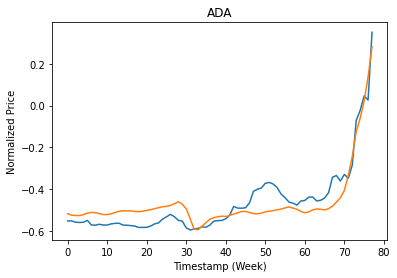

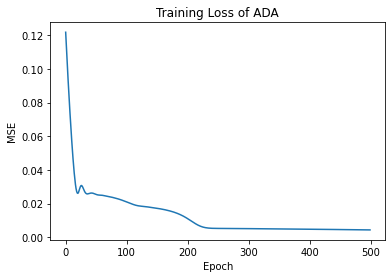

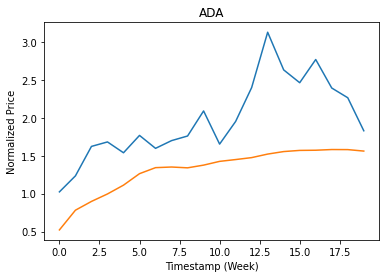

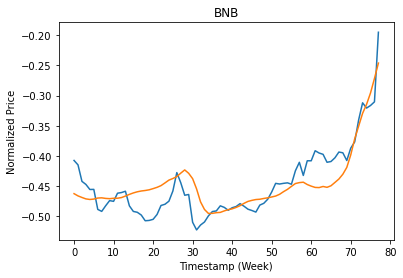

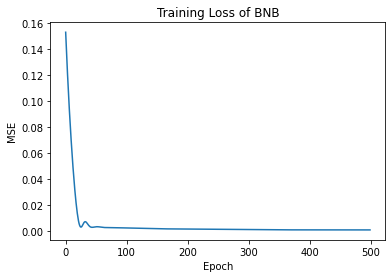

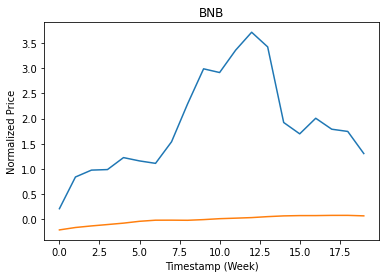

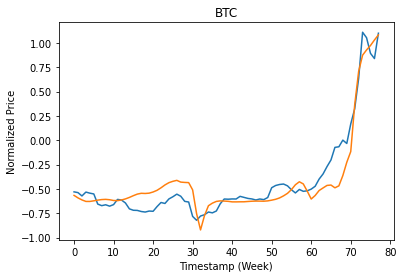

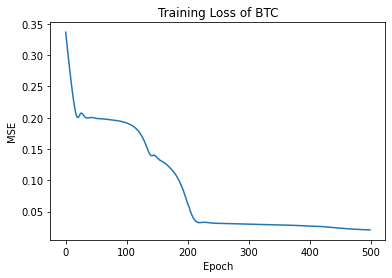

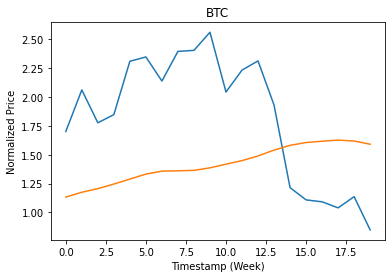

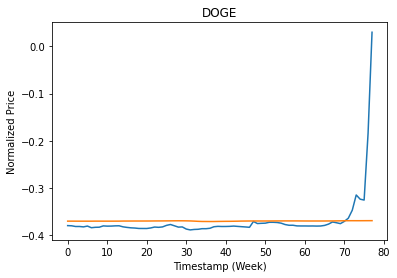

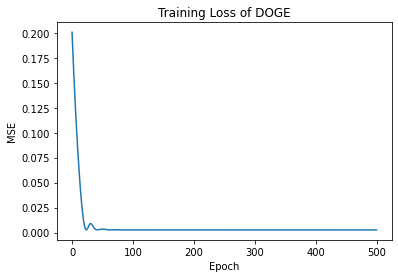

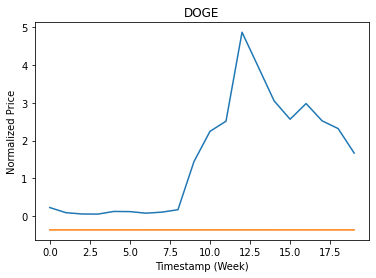

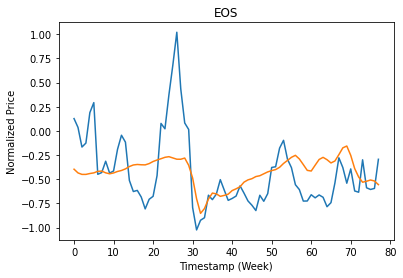

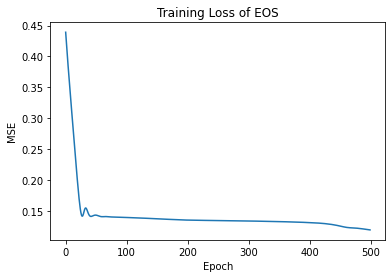

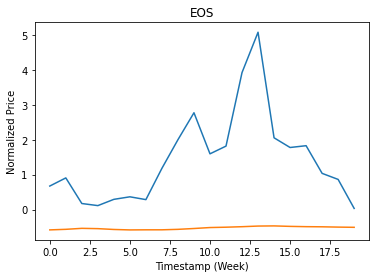

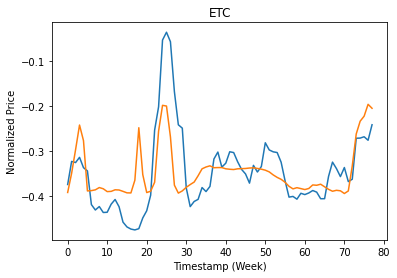

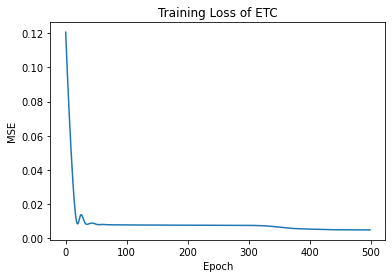

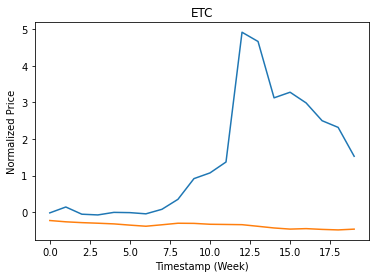

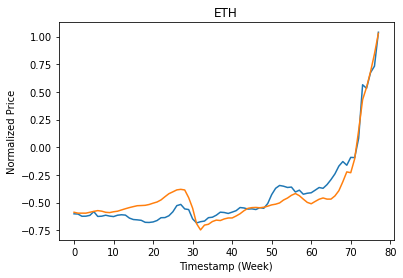

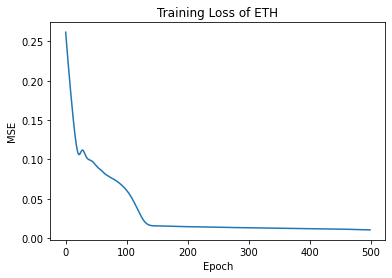

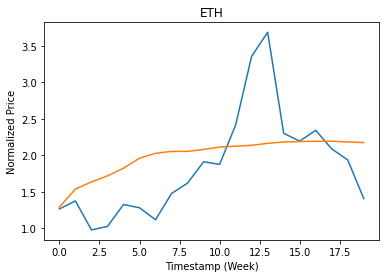

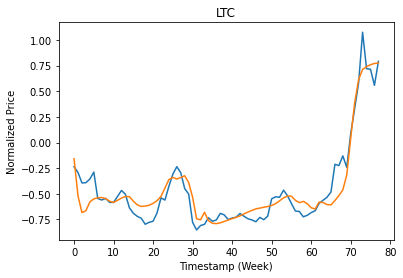

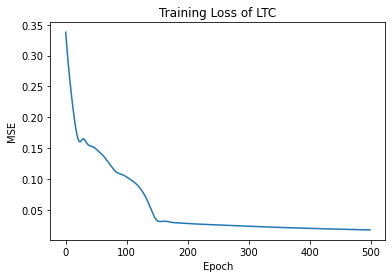

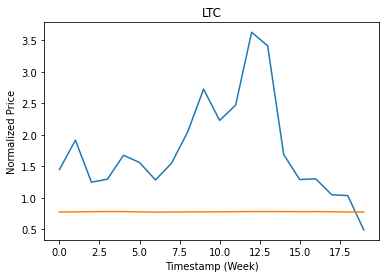

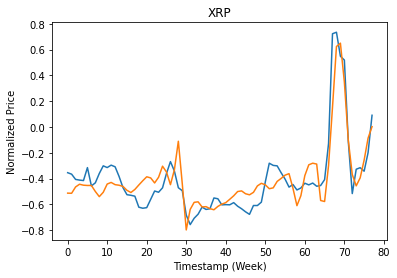

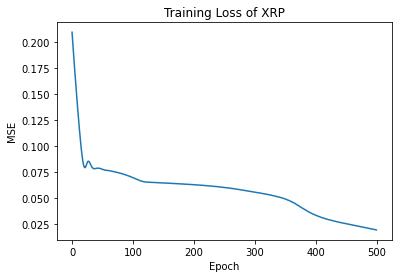

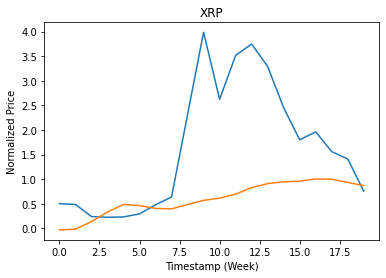

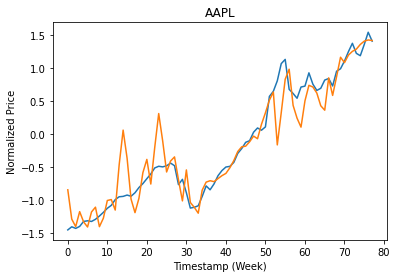

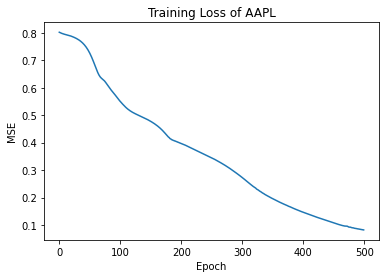

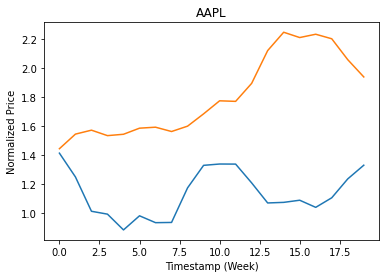

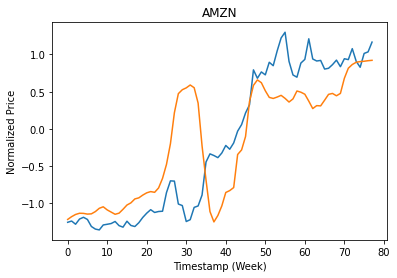

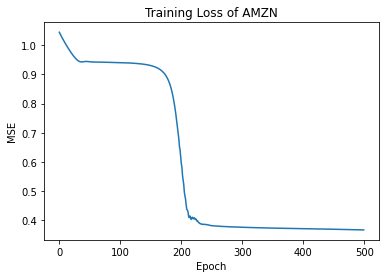

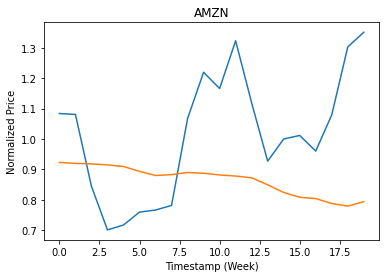

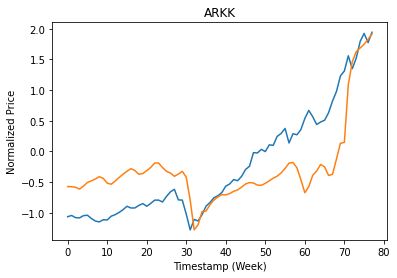

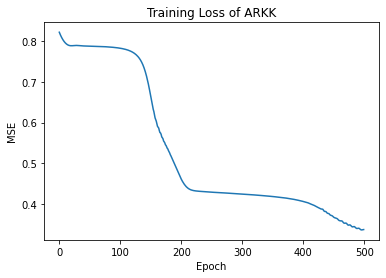

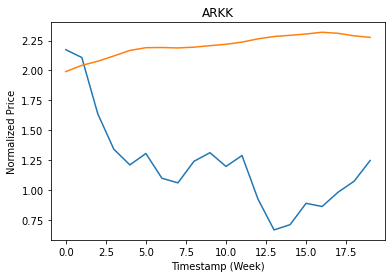

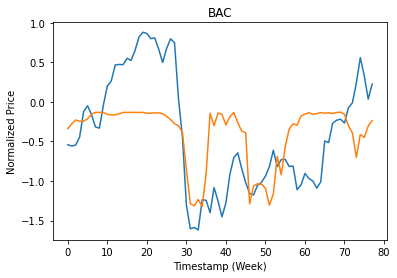

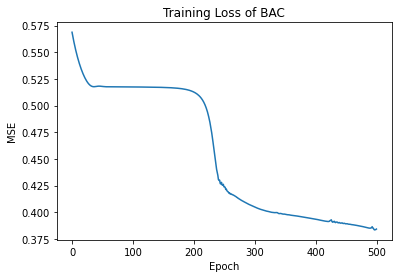

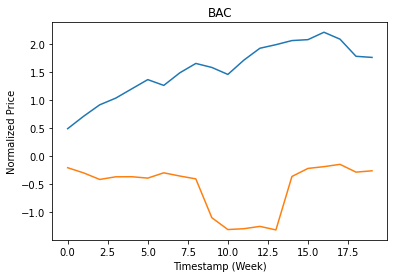

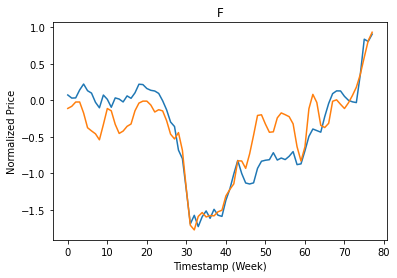

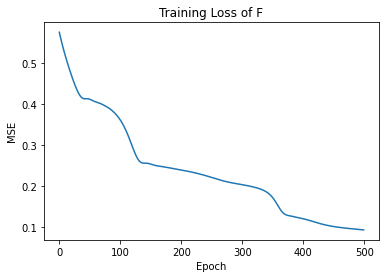

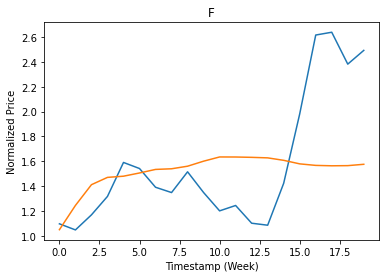

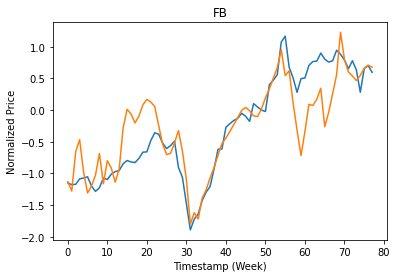

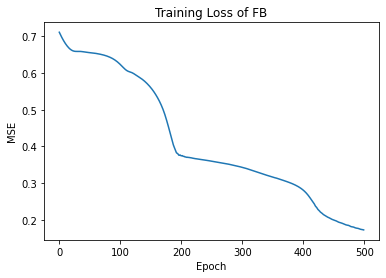

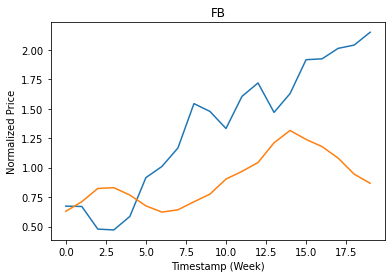

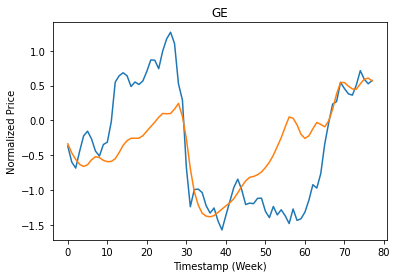

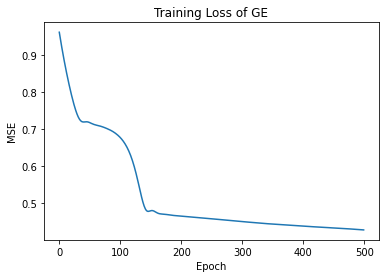

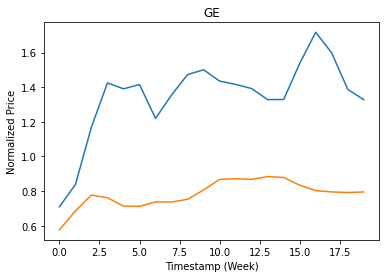

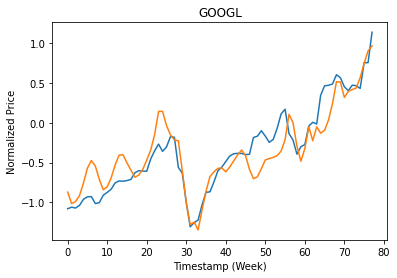

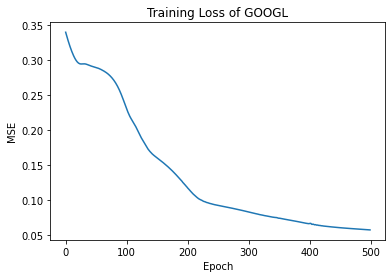

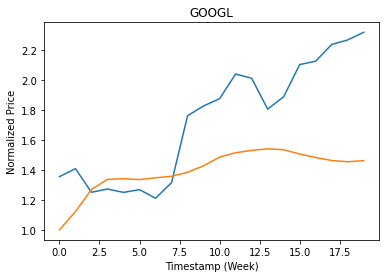

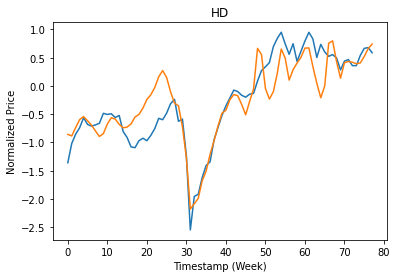

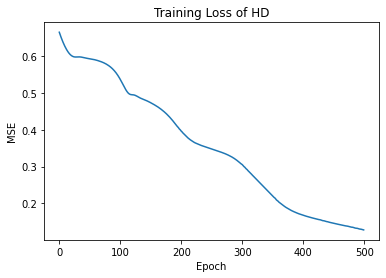

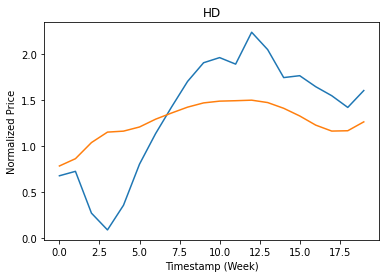

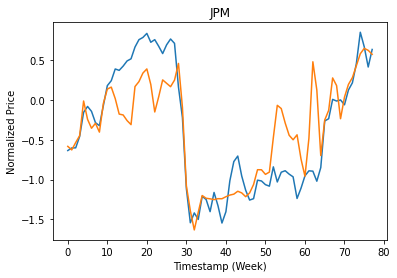

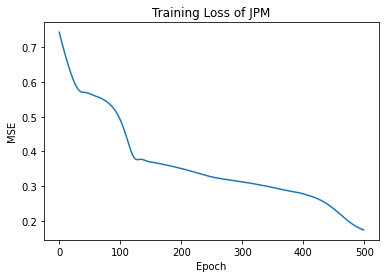

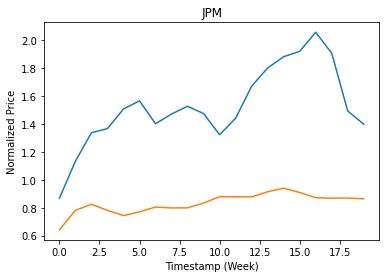

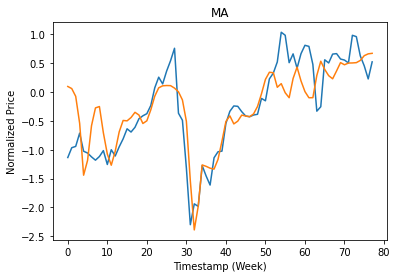

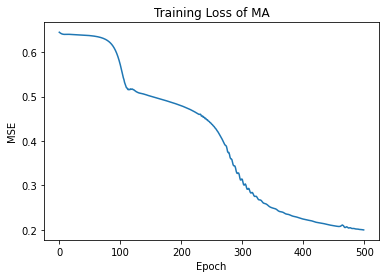

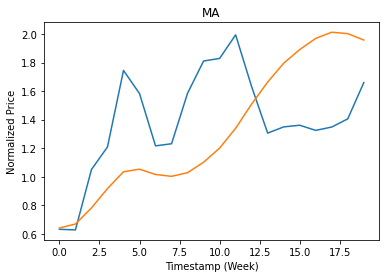

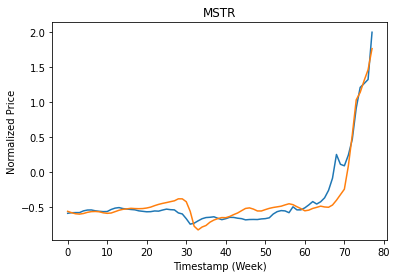

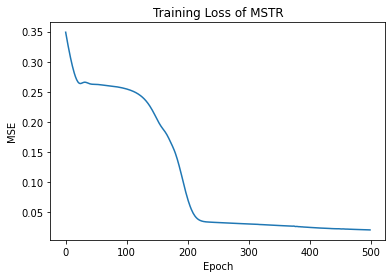

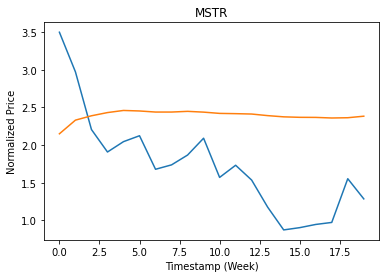

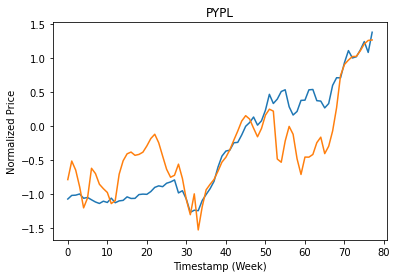

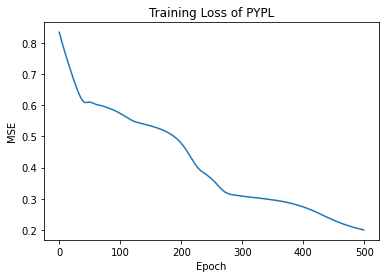

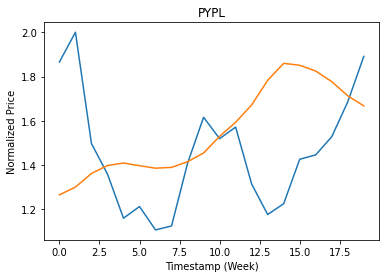

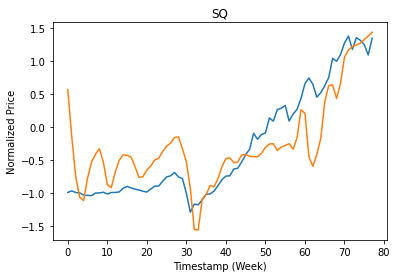

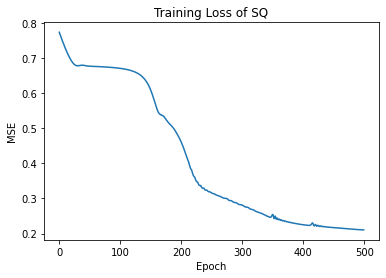

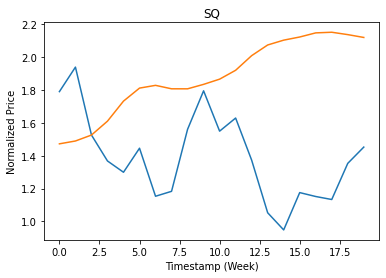

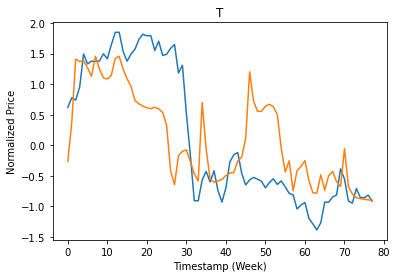

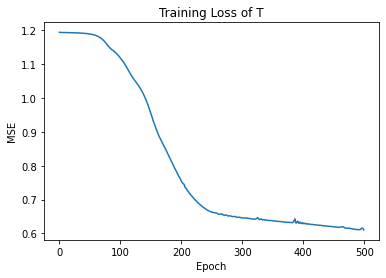

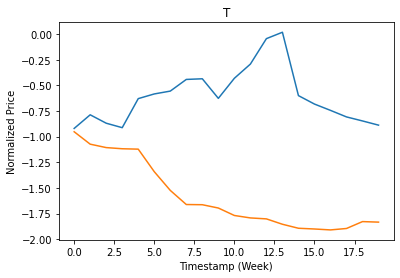

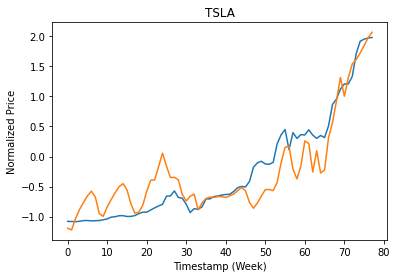

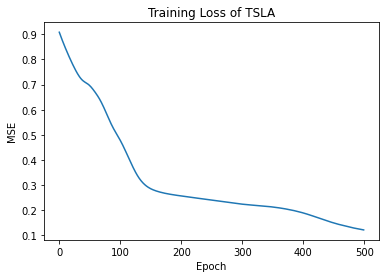

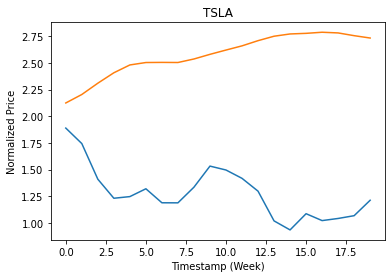

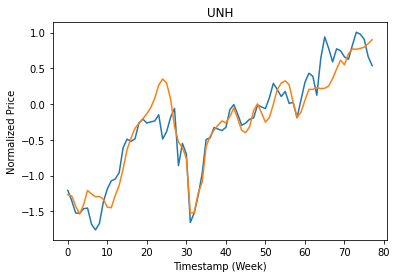

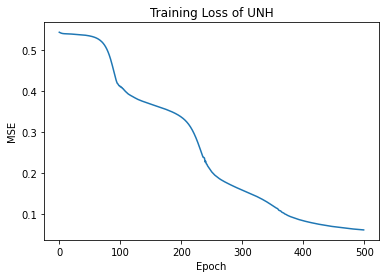

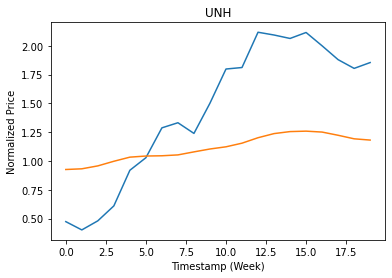

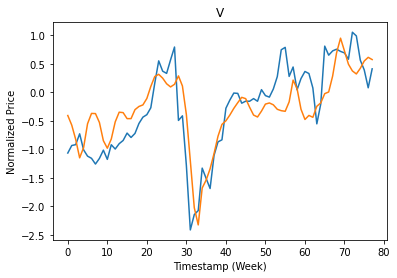

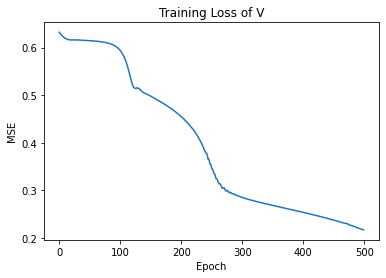

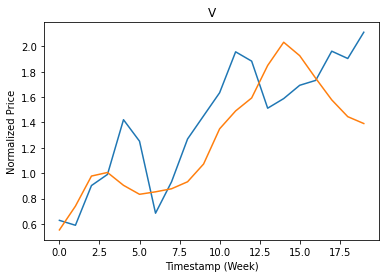

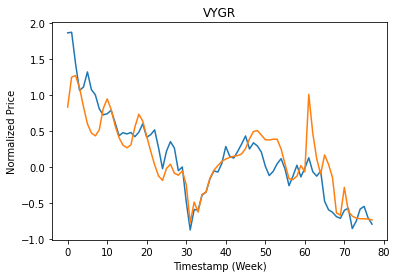

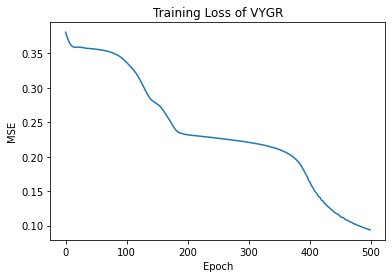

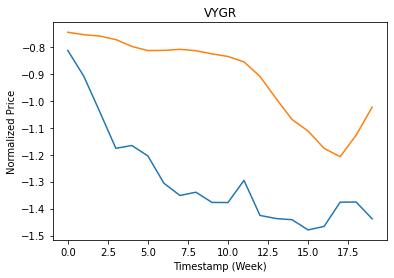

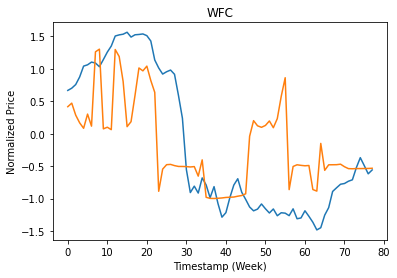

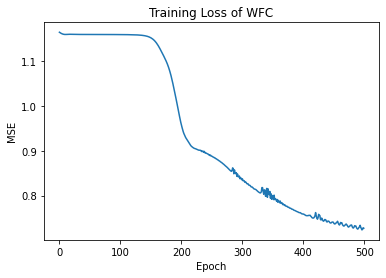

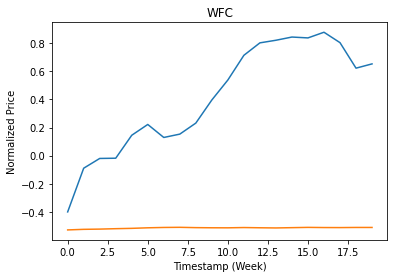

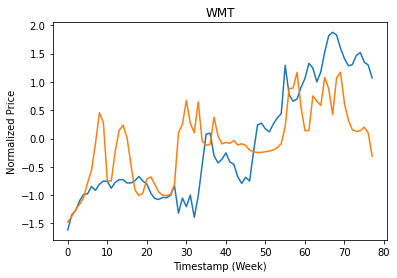

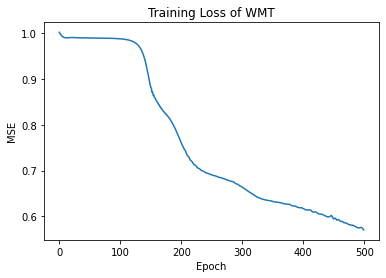

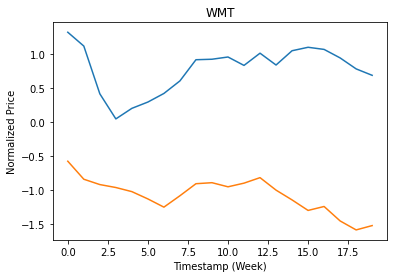

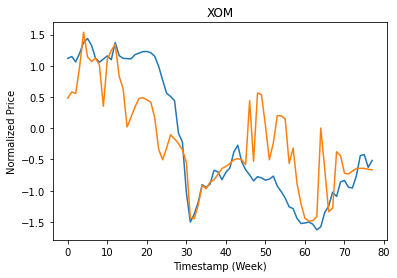

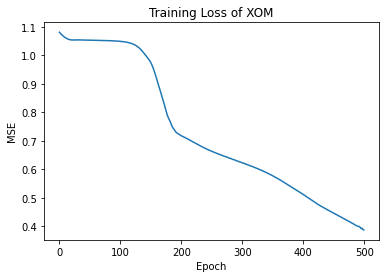

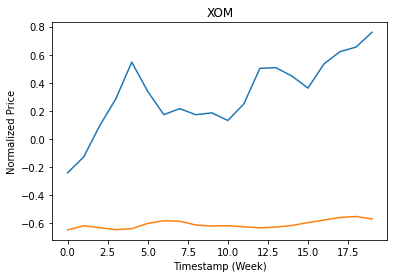

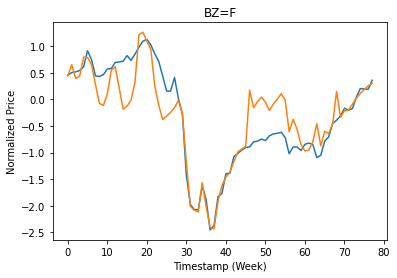

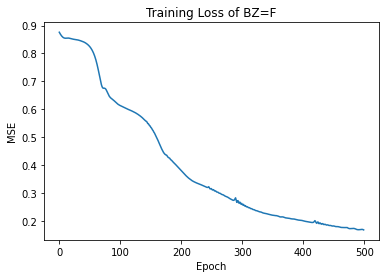

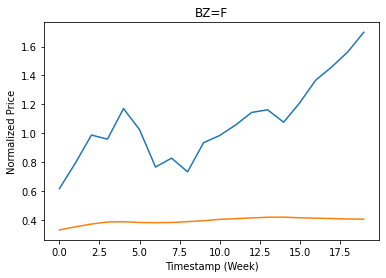

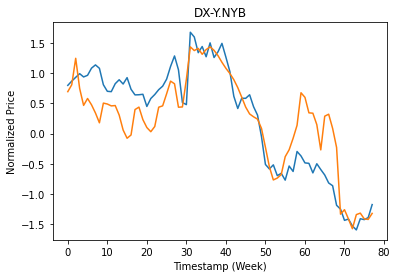

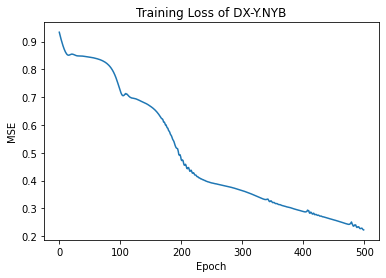

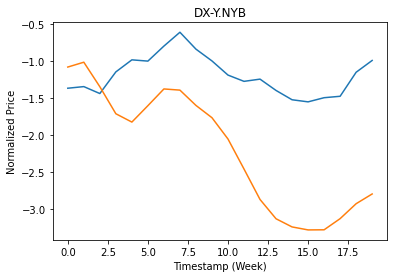

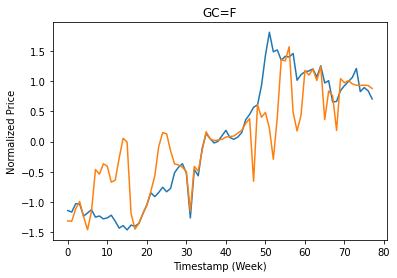

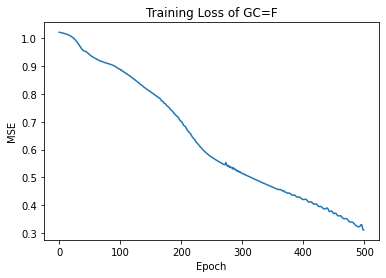

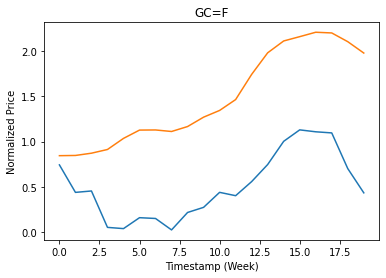

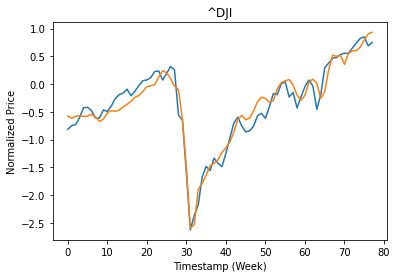

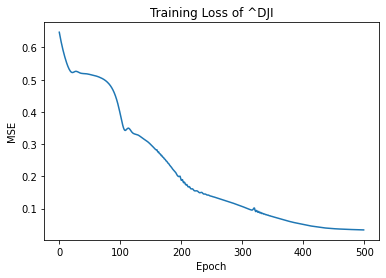

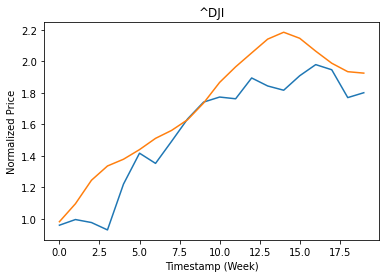

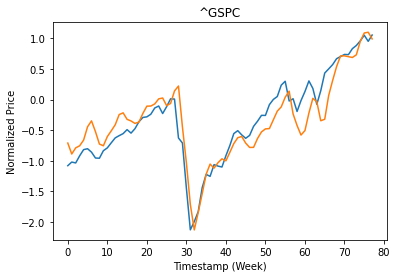

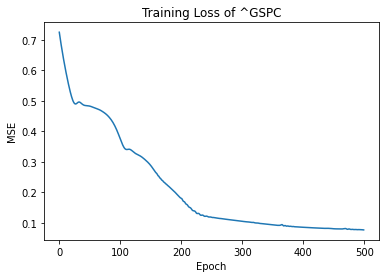

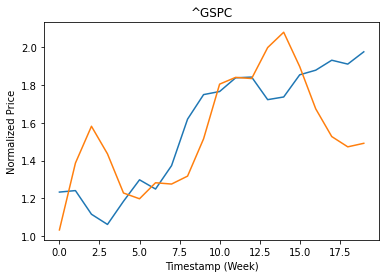

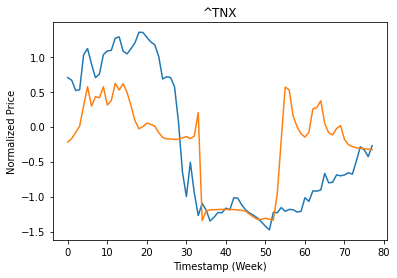

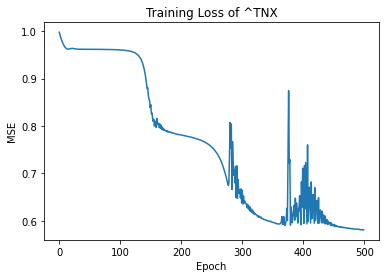

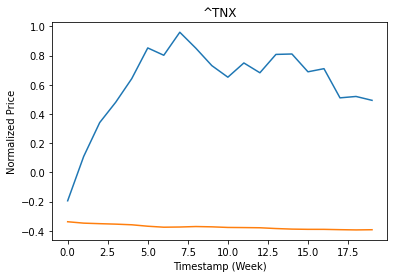

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

train_graphs = create_input_graph_set(train_data, len(names))
criteria = nn.MSELoss(reduction = "mean")

train_loss, test_loss, acc_result, c_tl, s_tl, o_tl, c_ta, s_ta, o_ta = [], [], [], [], [], [], [], [], []

for asset_id in range(len(names)):
    all_train_y, train_y = get_all_y_and_y(train_data, names, N, asset_id)
    
    if names[asset_id] in crypto:
        used_L = L[0]
        
    elif names[asset_id] in stock:
        used_L = L[1]
        
    elif names[asset_id] in others: 
        used_L = L[2]
        
    m, loss_list =training(train_graphs, train_y, asset_id, used_L, device)
    pred_train = m(train_graphs)
    plot_prediction_against_truth(pred_train, train_y, asset_id) 
    # plot the pred_vs_truth for test
    
    plot_loss(loss_list, asset_id)
    # plot loss
    
    train_loss.append(criteria(pred_train, train_y.to(device)).item())          
    test_graphs = create_input_graph_set(test_data, len(names))
    all_test_y, test_y= get_all_y_and_y(test_data, names, N, asset_id)
    m.set_gat_num(len(test_data))

    pred_test = m(test_graphs)
    tl = criteria(pred_test, test_y.to(device)).item()
    test_loss.append(tl)
    plot_prediction_against_truth(pred_test, test_y, asset_id) 
    # plot the pred_vs_truth for train
    
    validation_actual = np.sign(test_data.iloc[N-1:-1, asset_id+1:asset_id+2].copy().to_numpy() - test_y.detach().to('cpu').numpy())
    #validation_pred = np.sign(np.concatenate((test_data.iloc[N-1:N, 36+1:36+2].copy().to_numpy(), pred_test.detach().to('cpu').numpy()[:-1]), axis=0) - pred_test.detach().to('cpu').numpy())
    validation_pred = np.sign(test_data.iloc[N-1:-1, asset_id+1:asset_id+2].copy().to_numpy() - pred_test.detach().to('cpu').numpy())
    acc = sum(validation_actual == validation_pred) / pred_test.shape[0]
    acc_result.append(acc)
    
    if names[asset_id] in crypto:
        c_tl.append(tl)
        c_ta.append(acc)
        
    elif names[asset_id] in stock:
        s_tl.append(tl)
        s_ta.append(acc)
        
    elif names[asset_id] in others:
        o_tl.append(tl)
        o_ta.append(acc)
        

### Output Result

In [13]:
print("Average MSE for all assets on test data is \t \t" + str(sum(test_loss)/len(test_loss)))
print("Average MSE for crypto data only on test data is \t" + str(sum(c_tl)/len(c_tl)))
print("Average MSE for stock data only on test data is \t" + str(sum(s_tl)/len(s_tl)))
print("Average MSE for other data only on test data is \t" + str(sum(o_tl)/len(o_tl)))
print()
print("Average accuracy for all assets on test data is \t" + str(float(sum(acc_result)/len(acc_result))))
print("Average accuracy for crypto data only on test data is \t" + str(float(sum(c_ta)/len(c_ta))))
print("Average accuracy for stock data only on test data is \t" + str(float(sum(s_ta)/len(s_ta))))
print("Average accuracy for other data only on test data is \t" + str(float(sum(o_ta)/len(o_ta))))

Average MSE for all assets on test data is 	 	1.37200511800679
Average MSE for crypto data only on test data is 	3.008125924401813
Average MSE for stock data only on test data is 	0.8850632381032814
Average MSE for other data only on test data is 	0.7032774680604538

Average accuracy for all assets on test data is 	0.8013513513513513
Average accuracy for crypto data only on test data is 	0.6166666666666667
Average accuracy for stock data only on test data is 	0.8272727272727273
Average accuracy for other data only on test data is 	0.9833333333333334


Mark - upload base version for everyone to work off of to main drive - put all old versions in 'archive'

YF     - Recap

H/K  - add more assets

H/K  - determine feature importance manually

H/K  - weekly average

YF     - latent feature transform

M      - split by asset class - lstm

Y       - split by asset class - gru

Y       - attention coefficient extraction

M      - GATv2

ALL   -  performance comparison